
# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch
import tmol.score.ljlk.jit_score_graph
import tmol.score.ljlk.cpp_potential

In [6]:
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [7]:
import toolz

In [8]:
decoys = toolz.keyfilter(lambda k: k>200 and k<500, tmol.tests.data.structures_bysize())

In [9]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame, stat_profile

torch.set_num_threads(1)

rosetta_score_results = []
scores = {}
profiles = {}

for dsize, d in decoys.items():
    model_name = f"BYSIZE_{dsize}"

    work_pose = d.stripped_pose.pose

    logging.info(dsize)

    fixture = make_fixture(
        "score",
        rosetta_score_results.append,
        nres=len(work_pose.residues),
        natoms=len(d.tmol_coords),
        model=model_name,
        max_time=.25,
        use_cprofile=True,
        
    )

    logging.info("Rosetta")
    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta", device="cpu")
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)
    
    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        )
    )

    for n, sg in score_graphs.items():
        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj

        for ptype in tmol.score.ljlk.cpp_potential.potentials:
            tmol.score.ljlk.cpp_potential.POTENTIAL_SET = ptype

            gfix = make_subfixture(
                fixture, f".{n}.{ptype}", impl=ptype, device=sg.device.type
            )

            @gfix
            def benchmark_score_graph():
                sg.coords = sg.coords
                return sg.intra_score().total_lj

            scores.setdefault(model_name, {})[gfix.name] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores[model_name].items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:400
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -1653.4115141856676 score.tmol_lj_cpu_cpp.blocked: tensor([710.3551]) score.tmol_lj_cpu_cpp.naive: tensor([710.3551])
INFO:root:250
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -1119.8932213914081 score.tmol_lj_cpu_cpp.blocked: tensor([-716.1954]) score.tmol_lj_cpu_cpp.naive: tensor([-716.1954])
INFO:root:300
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -1595.3013226696185 score.tmol_lj_cpu_cpp.blocked: tensor([nan]) score.tmol_lj_cpu_cpp.naive: tensor([nan])


In [10]:
import operator
def sum(v):
    return toolz.reduce(operator.add, v)

In [11]:
import pandas

In [12]:
import altair
altair.themes.register("vis", lambda: dict(config={
        "view": {"height": 500, "width": 800},
        "axis": {"labelFontSize": 16, "titleFontSize": 16},
        "legend": {"labelFontSize": 16, "titleFontSize": 16},
        "header": {"labelFontSize": 16, "titleFontSize": 16},
        "title": {"fontSize": 16},
    }))
altair.themes.enable("vis")
altair.data_transformers.enable('default', max_rows=20e3)

pass

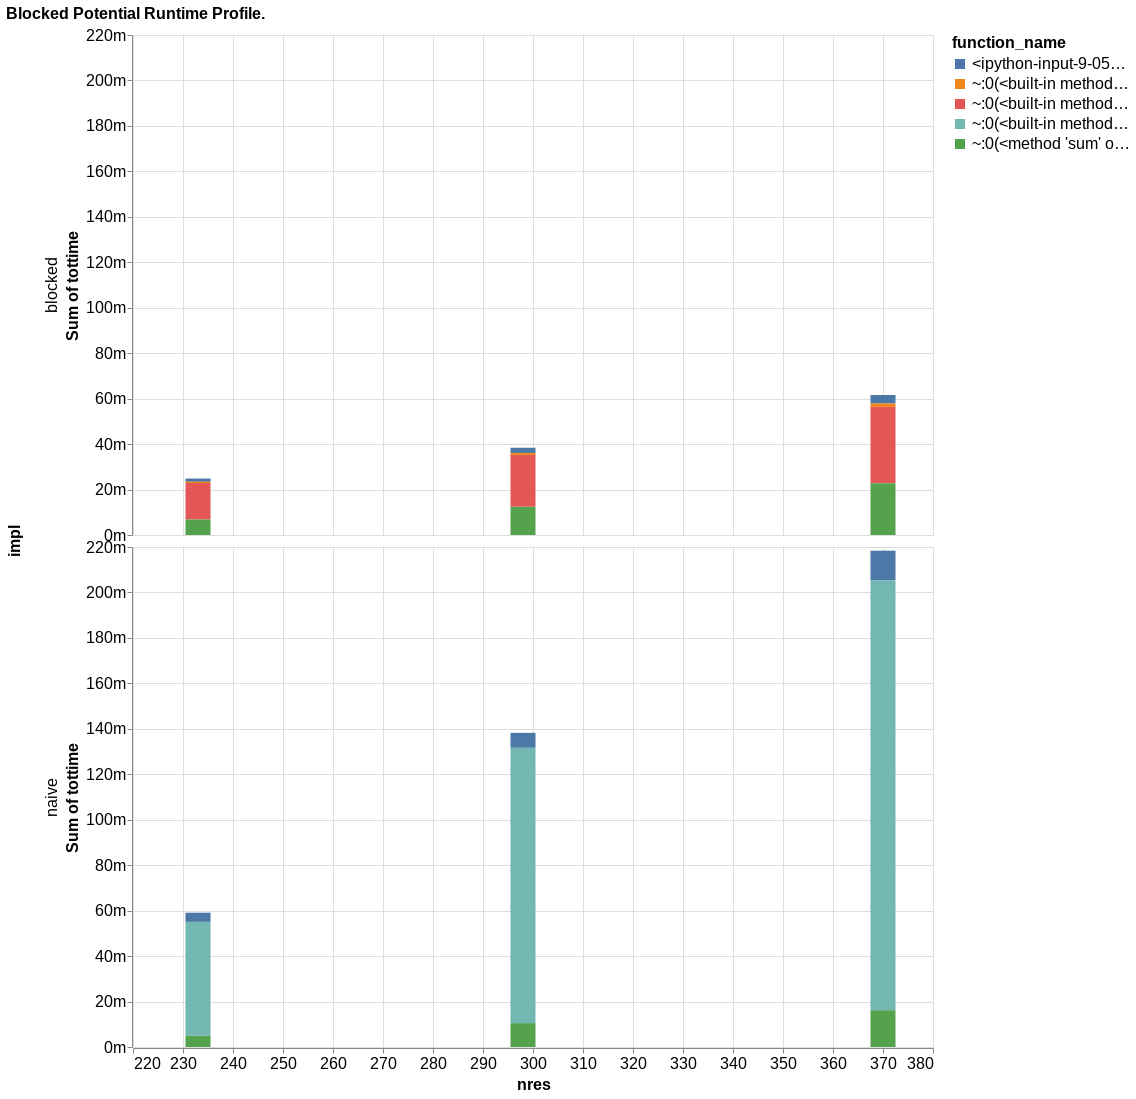

In [13]:
pdat = stat_profile(rosetta_score_results)
pdat = pdat.query("impl != 'rosetta'")
rdat = pdat.query("tottime > 100e-6 and fractime > 1e-3")

encoding = dict(
    x="nres",
    y=altair.Y("sum(tottime)", axis=altair.Axis(format="s")),
    color="function_name",
    row="impl"
)

c = (
    altair.Chart(rdat).mark_bar().encode(**encoding)
#    + altair.Chart(pdat).mark_line().encode(x="nres", y="sum(tottime)")
).configure(bar={"continuousBandSize": 25})
c.title="Blocked Potential Runtime Profile."
c

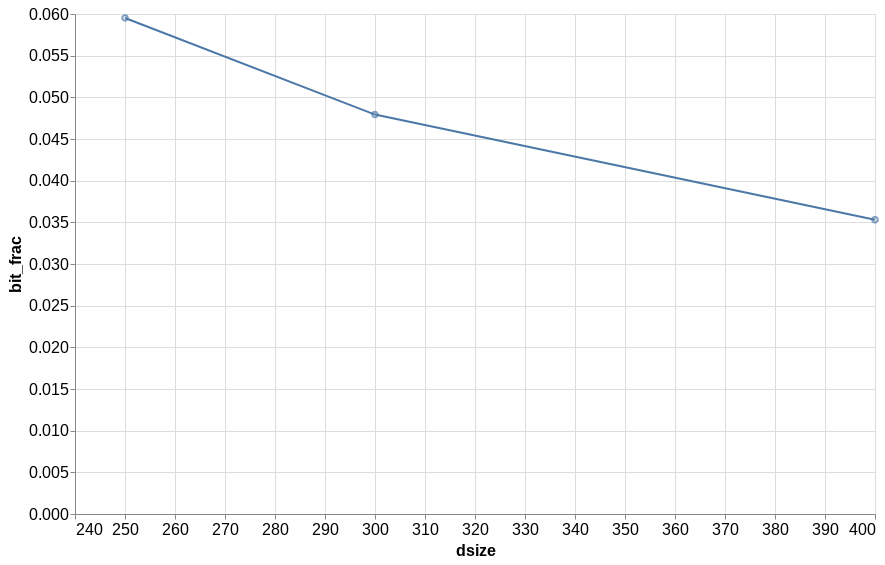

In [14]:
rec = []
for dsize, d in decoys.items():
    bit = tmol.score.ljlk.cpp_potential.cpu.block_interaction_table(d.tmol_coords, 6.0)
    bit_frac = float(bit.sum() / (bit.shape[0] * bit.shape[1]))
    rec.append(dict(dsize=dsize, bit_frac=bit_frac))

c = altair.Chart(pandas.DataFrame.from_records(rec))

sum([c.mark_line().encode(x="dsize", y="bit_frac"), c.mark_point().encode(x="dsize", y="bit_frac")])

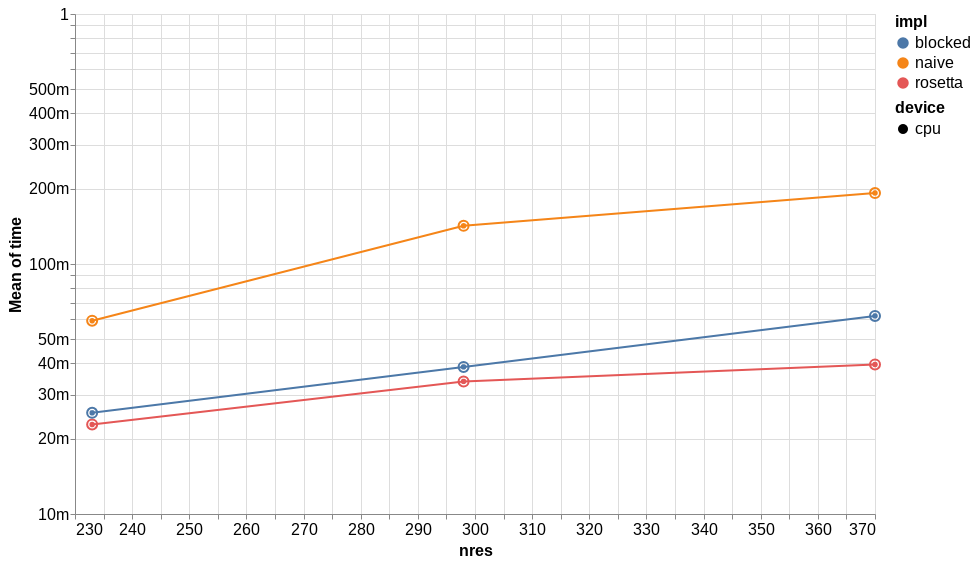

In [15]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

encoding = dict(
        x="nres",
        y=altair.Y(
            "mean(time)",
            scale=altair.Scale(type="log", base=10),
            axis=altair.Axis(format="s"),
        ),
        color="impl",
        shape="device",
)

c = (
    altair.Chart(dat)
    .mark_line()
    .encode(**encoding)
     +
    altair.Chart(dat)
    .mark_point(size=100)
    .encode(**encoding)
)
c

In [16]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("natoms")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("natoms", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cpu_cpp.blocked", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
natoms,,,
4128,0.022797,0.023008,0.000119
5408,0.033915,0.034862,0.000473
7176,0.039630,0.039759,0.000069


,rosetta_relative,time,fold_acceleration
natoms,,,
4128,1.113519,0.025385,0.898054
5408,1.142863,0.038760,0.874996
7176,1.564057,0.061983,0.639363
